##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural style transfer

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/style_transfer"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/style_transfer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

### Original tutorial Notebook is from this link:
https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb

### Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

### This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

### This Notebook take the **fast style transfer using TF-Hub** part from the original source and extended to **video style transfer**. It is a lot of fun to play style transfer.

Note: A pretrained [Arbitrary Image Stylization module](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_arbitrary_image_stylization.ipynb) is available in [TensorFlow Hub](https://tensorflow.org/hub), and for [TensorFlow Lite](https://www.tensorflow.org/lite/models/style_transfer/overview).



For example, let’s take an image of this dog and Wassily Kandinsky's Composition 7:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>

[Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), from Wikimedia Commons

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


Now how would it look like if Kandinsky decided to paint the picture of this Dog exclusively with this style? Something like this?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

## Setup


## Import and configure modules

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import tensorflow as tf

In [3]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [5]:
ContentPath='/content/drive/My Drive/computer_vision/style_transfer/image/'
StylePath='/content/drive/My Drive/computer_vision/style_transfer/style/'
base_image_path = ContentPath+'TR.jpg'
style_image_path = StylePath+'Vassily_Kandinsky.jpg'

Download images and choose a style image and a content image:

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [6]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [7]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

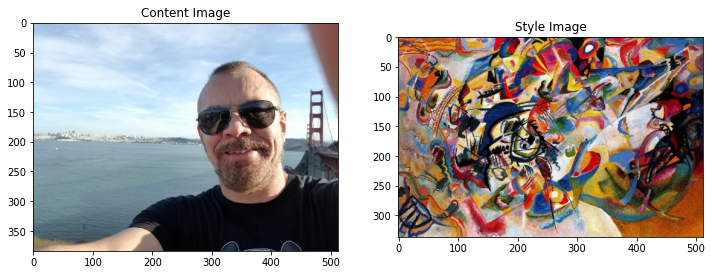

In [8]:
content_image = load_img(base_image_path)
style_image = load_img(style_image_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm, which optimizes the image content to a particular style. Before getting into the details, let's see how the [TensorFlow Hub](https://tensorflow.org/hub) module does:

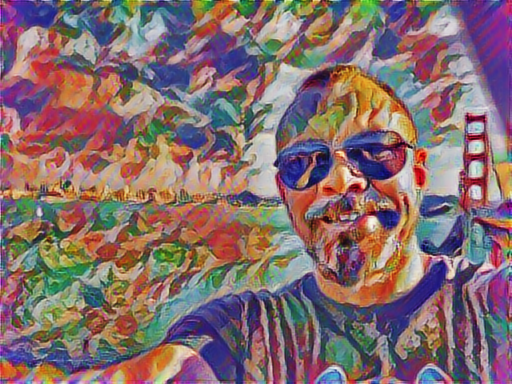

In [9]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)



```
# This is formatted as code
```

## Video Style Transfer using TF-Hub 


### Step 1 First Extract Images from a Video, function to split a video into image frames for style transfer

In [10]:
# Extract images from a video, method 1
import cv2
print(cv2.__version__)
videoDir='/content/drive/My Drive/computer_vision/style_transfer/video/'
imgDir='/content/drive/My Drive/computer_vision/style_transfer/content_img/'
vidcap = cv2.VideoCapture(videoDir+"lalaland1.mp4")
print (vidcap.read())
success,image = vidcap.read()
count = 0
success = True
while success:
    success,image = vidcap.read()
    print ('Read a new frame: ', success)
    cv2.imwrite(imgDir+"frame%d.jpg" % count, image)     # save frame as JPG file
    count += 1
    if count == 800:  # Estimated Based on 30 FPS X time of video (seconds)
        break

4.1.2
(True, array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8))
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame: 

In [13]:
# method2, another way to get images from video, much fast than method1
import cv2
import os

def video_to_frames(video, path_output_dir):
    # extract frames from a video and save to directory as 'x.png' where 
    # x is the frame index
    vidcap = cv2.VideoCapture(video)
    count = 0
    while vidcap.isOpened():
        success, image = vidcap.read()
        if success:
            cv2.imwrite(os.path.join(path_output_dir, '%d.jpg') % count, image)
            count += 1
        else:
            break
    cv2.destroyAllWindows()
    vidcap.release()
videoDir='/content/drive/My Drive/computer_vision/style_transfer/video/'
imgDir='/content/drive/My Drive/computer_vision/style_transfer/content/'
video_to_frames(videoDir + 'lalaland1.mp4', imgDir)

### Step 2 Style Transfer Image Frames using TF-Hub and Save images to slyled_image folder

In [ ]:
ContentPath='/content/drive/My Drive/computer_vision/style_transfer/content_img/'
StylePath='/content/drive/My Drive/computer_vision/style_transfer/style/'

In [ ]:
import os
frames_list=os.listdir(ContentPath)
for frame in frames_list:
    idx=frame[5:frame.find('.jpg')]
    #if int(idx)%2==0:
    print('process images: ', frame)
    content_image = load_img(os.path.join(ContentPath,frame))
    stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
    img=tensor_to_image(stylized_image)    
    img.save('/content/drive/My Drive/computer_vision/style_transfer/styled_image/'+frame)

process images:  frame0.jpg
process images:  frame1.jpg
process images:  frame2.jpg
process images:  frame3.jpg
process images:  frame4.jpg
process images:  frame5.jpg
process images:  frame6.jpg
process images:  frame7.jpg
process images:  frame8.jpg
process images:  frame9.jpg
process images:  frame10.jpg
process images:  frame11.jpg
process images:  frame12.jpg
process images:  frame13.jpg
process images:  frame14.jpg
process images:  frame15.jpg
process images:  frame16.jpg
process images:  frame17.jpg
process images:  frame18.jpg
process images:  frame19.jpg
process images:  frame20.jpg
process images:  frame21.jpg
process images:  frame22.jpg
process images:  frame23.jpg
process images:  frame24.jpg
process images:  frame25.jpg
process images:  frame26.jpg
process images:  frame27.jpg
process images:  frame28.jpg
process images:  frame29.jpg
process images:  frame30.jpg
process images:  frame31.jpg
process images:  frame32.jpg
process images:  frame33.jpg
process images:  frame34

### Step 3 Assemble Stylized Images into a Video

In [4]:
# Assemble images into a video
import cv2
import os

image_folder = '/content/drive/My Drive/computer_vision/style_transfer/styled_image'
video_name = image_folder+'/lalaland2.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 20, (width,height))  # FPS = 20

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()